### Classify each frame with ResNet-18 CNN

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [2]:
nb_classes = 8
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, nb_classes)

i = 0
for params in resnet18.parameters():
    if i < 6:
        params.requires_grad = False
    i += 1
#summary(resnet18, (3, 224, 224))

In [3]:
batch_size = 64
n_epochs = 10

is_cpu_available = torch.cuda.is_available()

#optimizer = optim.Adam(resnet18.parameters(), lr=2e-5, weight_decay=0.0001)
optimizer = optim.SGD(resnet18.parameters(), lr=0.00002, momentum=0.95, weight_decay=0.001)
criteria = nn.CrossEntropyLoss()

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(90),
            transforms.ColorJitter(brightness=0.75, contrast=0.75, saturation=0.75),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

train_dataset = ImageFolder('./dataset1_/train', train_transforms)
val_dataset = ImageFolder('./dataset1_/val', val_transforms)
test_dataset = ImageFolder('./dataset1_/test', test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=4, shuffle=False)
val_loader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=4, shuffle=False)

In [5]:
resnet18.train()

if is_cpu_available:
    resnet18.cuda()
    criteria.cuda()

losses_epoch_train = []
accuracy_epoch_train = []

losses_epoch_val = []
accuracy_epoch_val = []

writer = SummaryWriter()

# Training loop
for epoch in range(n_epochs):
    total = 0
    epoch_loss = 0
    epoch_correct = 0
    for ix, data in enumerate(train_loader):
        resnet18.zero_grad()
        
        img, label = data
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()

        # Forward pass
        outputs = resnet18.forward(img)
        loss = criteria(outputs, label)

        # Prevent gradient addition
        optimizer.zero_grad()

        # Gradient calculation
        loss.backward()

        # Optimization
        optimizer.step()

        # Train loss for iter
        epoch_loss += loss.item()

        # Train accuracy for iter
        _, predictions = torch.max(outputs.data, 1)
        correct_pediction = (predictions == label).sum()

        epoch_correct += correct_pediction
        total += len(label)
        
    losses_epoch_train.append(epoch_loss / len(train_loader))
    accuracy_epoch_train.append(epoch_correct / total)

    writer.add_scalars('loss', {'train loss': epoch_loss / len(train_loader)}, epoch)
    writer.add_scalars('acc', {'train acc': epoch_correct / total}, epoch)
    
    print('Epoch: {} - Train Loss: {} - Train Accuracy: {}'.format(epoch, epoch_loss / len(train_loader), epoch_correct / total))          

    with torch.no_grad():
        resnet18.eval()

        total = 0
        epoch_loss = 0
        epoch_correct = 0
        # Measure the performance in validation set.
        for ix, data in enumerate(val_loader):
            img, label = data

            if is_cpu_available:
                img = img.cuda()
                label = label.cuda()

            # Test forward
            outputs = resnet18.forward(img)
            loss = criteria(outputs, label)

            # Test loss for iter
            epoch_loss += loss.item()

            # Train accuracy for iter
            _, predictions = torch.max(outputs.data, 1)
            correct_pediction = (predictions == label).sum()

            epoch_correct += correct_pediction
            total += len(label)
            
        losses_epoch_val.append(epoch_loss / len(val_loader))
        accuracy_epoch_val.append(epoch_correct / total)

        writer.add_scalars('loss', {'val loss': epoch_loss / len(val_loader)}, epoch)
        writer.add_scalars('acc', {'val acc': epoch_correct / total}, epoch)

        print('Epoch: {} - Val Loss: {} - Val Accuracy: {}'.format(epoch, epoch_loss / len(val_loader), epoch_correct / total))          

    resnet18.train()
    
writer.close()

Epoch: 0 - Train Loss: 2.0223751306533813 - Train Accuracy: 0.20152445137500763
Epoch: 0 - Val Loss: 1.8121536038815975 - Val Accuracy: 0.3055003583431244
Epoch: 1 - Train Loss: 1.7646518020068898 - Train Accuracy: 0.3720022439956665
Epoch: 1 - Val Loss: 1.6726270020008087 - Val Accuracy: 0.37243208289146423
Epoch: 2 - Train Loss: 1.594485598451951 - Train Accuracy: 0.47499537467956543
Epoch: 2 - Val Loss: 1.5611149358252685 - Val Accuracy: 0.4082173705101013
Epoch: 3 - Train Loss: 1.4410934251897476 - Train Accuracy: 0.5486149787902832
Epoch: 3 - Val Loss: 1.4601957847674687 - Val Accuracy: 0.4791252613067627
Epoch: 4 - Train Loss: 1.3259785203372731 - Train Accuracy: 0.5975088477134705
Epoch: 4 - Val Loss: 1.4002999514341354 - Val Accuracy: 0.5255135893821716
Epoch: 5 - Train Loss: 1.223727743765887 - Train Accuracy: 0.6365495920181274
Epoch: 5 - Val Loss: 1.3286201807980735 - Val Accuracy: 0.5222001671791077
Epoch: 6 - Train Loss: 1.1223911629003638 - Train Accuracy: 0.6623908281326

tensorboard --logdir runs

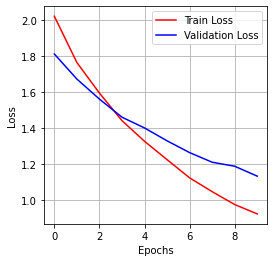

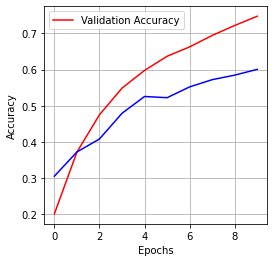

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(losses_epoch_train , color='r')
plt.plot(losses_epoch_val, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

fig, ax = plt.subplots(figsize=(4, 4))
plt.plot(accuracy_epoch_train , color='r')
plt.plot(accuracy_epoch_val, color='b')
plt.legend(["Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
ax.grid(True)

Test Accuracy: % 0.615321934223175 


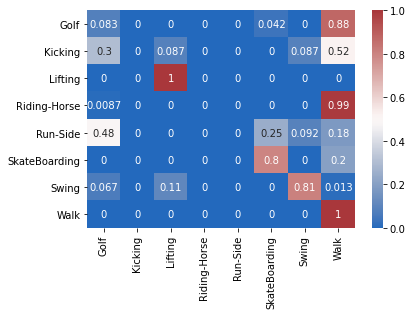

In [33]:
from sklearn.metrics import confusion_matrix

resnet18.eval()

targets = []
predicts = []
labs = ['Golf', 'Kicking', 'Lifting', 'Riding-Horse', 'Run-Side', 'SkateBoarding', 'Swing', 'Walk']

with torch.no_grad():
    total = 0
    correct_prediction = 0
    for data in test_loader:
        img, label = data
        
        if is_cpu_available:
            img = img.cuda()
            label = label.cuda()
        
        outputs = resnet18.forward(img)

        _, predictions = torch.max(outputs.data, 1)
        correct_prediction += (predictions == label).sum()
        
        total += len(label)
        
        preds = predictions.detach().cpu().numpy()
        labels = label.detach().cpu().numpy()
        
        for i in range(len(preds)):
            targets.append(labels[i])
            predicts.append(preds[i])

    print('Test Accuracy: % {} '.format(correct_prediction / total))
    
    matrix = confusion_matrix(targets, predicts, normalize = 'true')
    sn.heatmap(matrix, annot=True, cmap = sn.color_palette("vlag", as_cmap=True), xticklabels=labs, yticklabels=labs)